# $N^2$-Queens — MCMC



In [14]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['axes.grid'] = True


## State representation

Each column (i, j) stores a height in [0, N), so the state is an integer N x N matrix.


In [15]:
def random_state(N, rng=None):
    """
    Initialize an N x N height matrix.
    Each row is an independent random permutation of [0, N).
    """
    if rng is None:
        rng = np.random.default_rng()

    state = np.empty((N, N), dtype=int)
    base = np.arange(N)
    for i in range(N):
        state[i] = rng.permutation(base)

    return state

def get_positions(state):
    """Flatten the height matrix into queen coordinates [(i, j, k), ...]."""
    N = state.shape[0]
    positions = []
    for i in range(N):
        for j in range(N):
            positions.append((i, j, int(state[i, j])))
    return positions


## Energy model

In [16]:
def queens_attack(p1, p2):
    """Return True if two queens attack each other in 3D."""
    i1, j1, k1 = p1
    i2, j2, k2 = p2
    di, dj, dk = i1 - i2, j1 - j2, k1 - k2

    if di == 0 and dj == 0 and dk == 0:
        return False

    if (di == 0 and dj == 0) or (di == 0 and dk == 0) or (dj == 0 and dk == 0):
        return True

    adi, adj, adk = abs(di), abs(dj), abs(dk)

    if dk == 0 and adi == adj and adi != 0:
        return True
    if dj == 0 and adi == adk and adi != 0:
        return True
    if di == 0 and adj == adk and adj != 0:
        return True
    if adi == adj == adk and adi != 0:
        return True
    return False

def compute_energy(state):
    """Compute number of attacking queen pairs (O((N^2)^2))."""
    queens = get_positions(state)
    E = 0
    for idx in range(len(queens)):
        for jdx in range(idx + 1, len(queens)):
            if queens_attack(queens[idx], queens[jdx]):
                E += 1
    return E


def compute_delta_energy(state, i, j1, j2):
    """
    Compute energy change when swapping two entries in the same row i:
        (i, j1, h1) <-> (i, j2, h2).

    Args:
        state: Current N x N height matrix.
        i: Row index (0-based).
        j1, j2: Column indices (0-based), j1 != j2.

    Returns:
        ΔE = E_new - E_old
    """
    N = state.shape[0]

    h1 = int(state[i, j1])
    h2 = int(state[i, j2])

    # Before swap
    old1 = (i, j1, h1)
    old2 = (i, j2, h2)
    # After swap
    new1 = (i, j1, h2)
    new2 = (i, j2, h1)

    old_conf = 0
    new_conf = 0

    # Conflicts with all other cells (except the two being swapped)
    for r in range(N):
        for c in range(N):
            if r == i and (c == j1 or c == j2):
                continue
            pos = (r, c, int(state[r, c]))

            if queens_attack(old1, pos):
                old_conf += 1
            if queens_attack(old2, pos):
                old_conf += 1

            if queens_attack(new1, pos):
                new_conf += 1
            if queens_attack(new2, pos):
                new_conf += 1

    # Conflicts between the two swapped positions themselves
    if queens_attack(old1, old2):
        old_conf += 1
    if queens_attack(new1, new2):
        new_conf += 1

    return new_conf - old_conf


## MCMC utility

In [17]:
class MCMC_result:
    """Container for storing the full MCMC trace and summary statistics."""
    def __init__(self, N, energies, betas, accepted_moves, final_state, min_energy, iterations, acceptance_curve):
        self.N = N
        self.energies = energies          # np.array of energies at each step
        self.betas = betas                # np.array of beta values
        self.accepted_moves = accepted_moves
        self.final_state = final_state    # final configuration
        self.min_energy = min_energy      # minimum energy observed
        self.iterations = iterations      # number of Metropolis updates performed
        self.acceptance_curve = acceptance_curve

def metropolis_step_single(state, beta, current_energy=None, rng=None):
    """
    Do one Metropolis update by swapping two columns within a single row.

    Args:
        state: Current N x N height matrix.
        beta: Inverse temperature.
        current_energy: Current energy (if None, will be computed).
        rng: Random number generator.

    Returns:
        (new_state, new_energy, accepted)
    """
    if rng is None:
        rng = np.random.default_rng()
    N = state.shape[0]

    if current_energy is None:
        current_energy = compute_energy(state)

    # Pick a random row and two distinct columns
    i = rng.integers(0, N)
    j1 = rng.integers(0, N)
    j2 = rng.integers(0, N)
    while j2 == j1:
        j2 = rng.integers(0, N)

    # ΔE for swapping (i, j1) <-> (i, j2)
    delta = compute_delta_energy(state, i, j1, j2)
    new_energy = current_energy + delta

    # Metropolis acceptance step
    if delta <= 0 or rng.random() < np.exp(-beta * delta):
        proposal = state.copy()
        proposal[i, j1], proposal[i, j2] = proposal[i, j2], proposal[i, j1]
        return proposal, new_energy, True

    return state, current_energy, False

        
def run_mcmc(
    N,
    beta=1.0,
    max_steps=20000,
    target_energy=0,
    seed=None,
    verbose=False,
    schedule="fixed",      # "fixed", "exponential", "geometric", "log"
    beta_end=None,
    cooling_rate=None,
):
    """
    Run a Metropolis MCMC / simulated annealing chain.

    Args:
        N: Board size (N x N base, heights in {0, ..., N-1}).
        beta: Inverse temperature parameter.
        max_steps: Maximum number of Metropolis updates.
        target_energy: Stop early if energy <= target_energy.
        seed: Random seed for reproducibility.
        schedule: 'fixed', 'exponential', 'geometric', or 'log'.
        beta_end: Final beta for 'geometric'/'log' schedules.
        cooling_rate: Factor (>1) for 'exponential' schedule.

    Returns:
        MCMC_result object containing the energy trace, final state, etc.
    """
    rng = np.random.default_rng(seed)

    state = random_state(N, rng)
    current_energy = compute_energy(state)

    energies = [current_energy]
    betas = []
    accepted = 0
    acceptance_curve = []

    for step in range(1, max_steps + 1):
        # Beta schedule
        if schedule == "fixed":
            beta_t = beta
        elif schedule == "exponential":
            if cooling_rate is None:
                raise ValueError("cooling_rate must be provided for schedule='exponential'")
            beta_t = beta * (cooling_rate ** (step / max_steps))
        elif schedule == "geometric":
            beta_t = beta * (beta_end / beta) ** (step/max_steps)
        else:
            raise ValueError(f"Unknown schedule: {schedule}")

        betas.append(beta_t)

        # One Metropolis update (swap two entries in one row)
        new_state, new_energy, accepted_flag = metropolis_step_single(
            state, beta_t, current_energy, rng
        )

        if accepted_flag:
            state = new_state
            current_energy = new_energy
            accepted += 1

        energies.append(current_energy)
        acceptance_curve.append(100.0 * accepted / step)

        if verbose and (step % 2000 == 0):
            print(
                f"step {step}: energy={current_energy}, beta={beta_t:.3f}, "
                f"acc={acceptance_curve[-1]:.1f}%"
            )

        if current_energy <= target_energy:
            if verbose:
                print(f"N={N}: Found energy {current_energy} at step {step}")
            break

    energies_arr = np.array(energies)
    betas_arr = np.array(betas)
    acc_arr = np.array(acceptance_curve)

    return MCMC_result(
        N=N,
        energies=energies_arr,
        betas=betas_arr,
        accepted_moves=accepted,
        final_state=state,
        min_energy=int(energies_arr.min()),
        iterations=len(betas_arr),
        acceptance_curve=acc_arr,
    )


In [18]:
def average_energy_over_runs(
    N,
    beta,
    beta_end=None,
    max_steps=20000,
    runs=8,
    schedule="fixed",
    base_seed=None,
    cooling_rate=1.001,
):
    """
    Run multiple MCMC chains and return:
      - per-run energy traces (padded to length max_steps+1)
      - mean energy per step
      - std of energy per step
      - number of runs that reached energy 0

    Args:
        N: Board size.
        beta: Inverse temperature (for annealing schedules, this is the initial beta).
        beta_end: Final beta for 'geometric' / 'log' schedules.
        max_steps: Maximum number of Metropolis updates per run.
        runs: Number of independent runs.
        schedule: 'fixed', 'exponential', 'geometric', or 'log'.
        base_seed: Base seed; if not None, seeds are base_seed + run_idx.
        cooling_rate: Growth factor for 'exponential' schedule.

    Returns:
        N: board size (for convenience)
        energies_matrix: array of shape (runs, max_steps+1)
        mean_energy:     array of shape (max_steps+1,)
        std_energy:      array of shape (max_steps+1,)
        num_zero_runs:   how many runs reached energy 0 at some point
    """
    traces = []
    num_zero_runs = 0

    it = range(runs)
    it = tqdm(it, desc=f"N={N}, schedule={schedule}", leave=False)

    for run_idx in it:
        seed = None if base_seed is None else base_seed + run_idx

        trace = run_mcmc(
            N=N,
            beta=beta,
            max_steps=max_steps,
            target_energy=0,   # stop as soon as energy reaches 0
            seed=seed,
            schedule=schedule,
            cooling_rate=cooling_rate,
            beta_end=beta_end,
            verbose=False,
        )

        energies = trace.energies  # length <= max_steps+1
        if trace.min_energy == 0:
            num_zero_runs += 1

        # pad to length max_steps+1 with the last value (if stopped early)
        if energies.size < max_steps + 1:
            pad_len = max_steps + 1 - energies.size
            last = energies[-1]
            energies = np.concatenate([energies, np.full(pad_len, last, dtype=energies.dtype)])

        traces.append(energies)

    energies_matrix = np.vstack(traces)
    mean_energy = energies_matrix.mean(axis=0)
    std_energy = energies_matrix.std(axis=0)
    print(f"N={N}, num_zero_runs={num_zero_runs}")

    return N, energies_matrix, mean_energy, std_energy


## Plot helper

In [19]:
def plot_energy_curve(result):
    steps = np.arange(len(result.energies))

    fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=True)

    # Energy trace
    axes[0].plot(steps, result.energies, color='steelblue', linewidth=1.5, label='energy')
    axes[0].set_ylabel('Energy')
    axes[0].set_title(f'Energy/Beta/Acceptance (N={result.N})')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend(loc='upper right')

    # Beta curve
    axes[1].plot(result.betas, color='coral', linewidth=1.5, label='beta')
    axes[1].set_ylabel('Beta')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend(loc='upper right')

    # Acceptance rate curve (stored directly in result)
    acc_curve = result.acceptance_curve
    step_axis = np.arange(acc_curve.size)
    axes[2].plot(step_axis, acc_curve, color='seagreen', linewidth=1.2, label='acc%')
    axes[2].set_xlabel('Step')
    axes[2].set_ylabel('Acc%')
    axes[2].grid(True, alpha=0.3)
    axes[2].legend(loc='lower right')

    plt.tight_layout()
    plt.show()

def plot_energy_curve_average(N, energies_matrix, mean_energy, std_energy):
    plt.figure(figsize=(6, 2))
    plt.plot(mean_energy, label='mean energy')
    plt.fill_between(
        range(len(mean_energy)),
        np.clip(mean_energy - std_energy, a_min=0, a_max=None),
        mean_energy + std_energy,
        alpha=0.2,
        label='±1 std',
    )
    plt.xlabel('Step')
    plt.ylabel('Energy')
    plt.title(f'Average energy trace over {energies_matrix.shape[0]} runs (N={N})')
    plt.grid(True, alpha=0.3)
    plt.legend()

def compare_annealing_effect(N, beta_fix1, beta_fix2, beta_exp, max_steps, runs, base_seed=None, cooling_rate=1.001):
    setups = [
        ("fixed β={}".format(beta_fix1), "fixed", beta_fix1),
        ("fixed β={}".format(beta_fix2), "fixed", beta_fix2),
        ("exponential start β={}".format(beta_exp), "exponential", beta_exp),
    ]

    plt.figure(figsize=(7, 4))
    steps = np.arange(max_steps + 1)
    for label, schedule, beta in setups:
        _, energies_matrix, mean_energy, std_energy = average_energy_over_runs(
            N,
            beta,
            max_steps,
            runs,
            schedule=schedule,
            base_seed=base_seed,
            cooling_rate=cooling_rate,
        )
        plt.plot(mean_energy, label=label)
        plt.fill_between(
            steps,
            np.clip(mean_energy - std_energy, a_min=0, a_max=None),
            mean_energy + std_energy,
            alpha=0.15,
        )

    plt.xlabel("Step")
    plt.ylabel("Mean energy ± std")
    plt.title(f"Annealing comparison over {runs} runs (N={N})")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


## MCMC without annealing

step 2000: energy=203, beta=1.000, acc=14.0%
step 4000: energy=190, beta=1.000, acc=11.4%
step 6000: energy=197, beta=1.000, acc=10.1%
step 8000: energy=185, beta=1.000, acc=9.7%
step 10000: energy=194, beta=1.000, acc=9.2%
step 12000: energy=189, beta=1.000, acc=9.3%
step 14000: energy=221, beta=1.000, acc=9.6%
step 16000: energy=190, beta=1.000, acc=9.8%
step 18000: energy=191, beta=1.000, acc=9.5%
step 20000: energy=206, beta=1.000, acc=9.7%
step 22000: energy=184, beta=1.000, acc=9.5%
step 24000: energy=183, beta=1.000, acc=9.3%
step 26000: energy=181, beta=1.000, acc=9.2%
step 28000: energy=176, beta=1.000, acc=8.9%
step 30000: energy=181, beta=1.000, acc=8.7%
step 32000: energy=194, beta=1.000, acc=8.6%
step 34000: energy=191, beta=1.000, acc=8.5%
step 36000: energy=197, beta=1.000, acc=8.5%
step 38000: energy=212, beta=1.000, acc=8.6%
step 40000: energy=198, beta=1.000, acc=8.6%
step 42000: energy=176, beta=1.000, acc=8.5%
step 44000: energy=177, beta=1.000, acc=8.4%
step 46000:

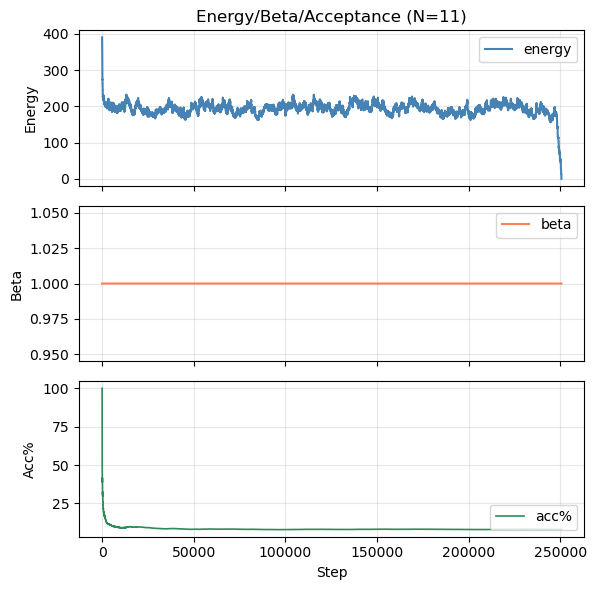

In [22]:
trace = run_mcmc(N=11, beta=1.0, max_steps=500000, verbose=True, schedule="fixed", seed=123)
plot_energy_curve(trace)

N=11, schedule=fixed:   0%|          | 0/8 [00:00<?, ?it/s]

N=11, num_zero_runs=8


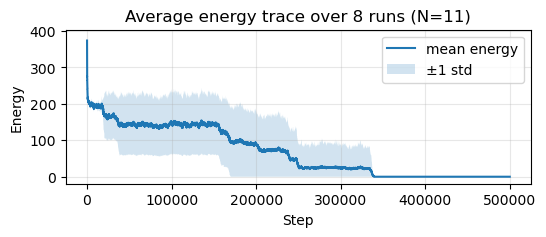

In [53]:
result = average_energy_over_runs(N=11, beta=1.0, max_steps=500000, runs=8, base_seed=123)
plot_energy_curve_average(*result)

step 2000: energy=1049, beta=1.000, acc=24.2%
step 4000: energy=939, beta=1.000, acc=17.6%
step 6000: energy=913, beta=1.000, acc=14.2%
step 8000: energy=904, beta=1.000, acc=12.7%
step 10000: energy=925, beta=1.000, acc=11.6%
step 12000: energy=879, beta=1.000, acc=11.2%
step 14000: energy=868, beta=1.000, acc=10.6%
step 16000: energy=885, beta=1.000, acc=10.1%
step 18000: energy=897, beta=1.000, acc=9.8%
step 20000: energy=911, beta=1.000, acc=9.6%
step 22000: energy=875, beta=1.000, acc=9.4%
step 24000: energy=880, beta=1.000, acc=9.1%
step 26000: energy=866, beta=1.000, acc=8.9%
step 28000: energy=848, beta=1.000, acc=8.7%
step 30000: energy=851, beta=1.000, acc=8.5%
step 32000: energy=847, beta=1.000, acc=8.3%
step 34000: energy=853, beta=1.000, acc=8.3%
step 36000: energy=853, beta=1.000, acc=8.2%
step 38000: energy=889, beta=1.000, acc=8.1%
step 40000: energy=890, beta=1.000, acc=8.1%
step 42000: energy=909, beta=1.000, acc=8.2%
step 44000: energy=898, beta=1.000, acc=8.1%
step 

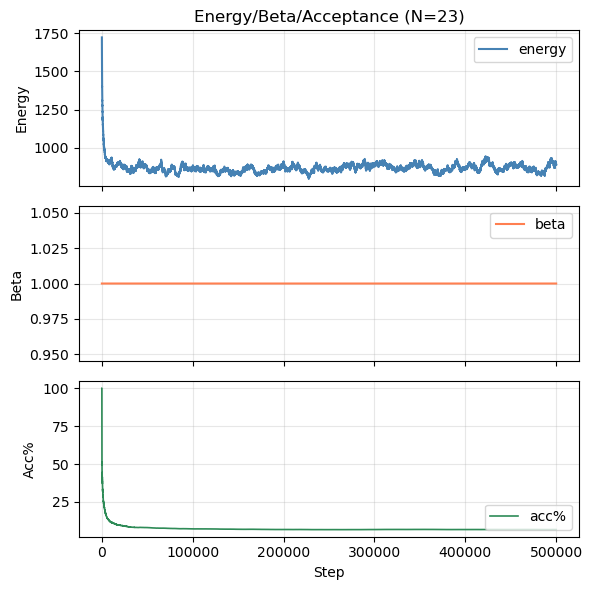

[[ 2 13 20  4  5 14  0  3 11 15  7 17 22  8 18 16 21  6  9 10 19 12  1]
 [16 21 17  2 13 19  5  3  0 14  1 15  9 10 20 11  4  8 18 12 22  6  7]
 [ 9  3  6 19  4 10  7 14 21  8  0 22 13  5 17 12  1 15  2 11 20 18 16]
 [16  3 15 12 21  6  2 11  7  4 22 19 17  1  8 14 10 20 18  9 13  0  5]
 [10  6  3  9 20  4 17 22 19  2 16 14 13  5 21 18  0 15 11  1  7  8 12]
 [ 4  9 12 19  5 11  2 20 17 16 18  6  3  7 21 13 15 22  8  1  0 14 10]
 [ 7 20  4 16 15 10 18  5  1 11  9 21 19 14  0  2 22  8 12  3  6 13 17]
 [ 5 12  8  6 21 13  0 20  3 17  9  4 15 22  7  2 16  1 10 18 11 19 14]
 [ 8 10  1 15  4  7 14 12  2 20 11 17 18  9  0 19  6 21  3 16 13 22  5]
 [14 21  4 11  3 12 15 10 22  9 20  7  0 13  1  8  6 16 19  5 18 17  2]
 [18 19 12 16  6  1  3 10  4 13 15  9 21 20 22  8 14  2 17  7  0 11  5]
 [20 16 13  8 14 18  7 19  2  6 17  3  4  0 12 10 22 11  1 21  5  9 15]
 [ 9  8 19  0 15 21 22  7 16  4 20 14 11 18  5  3 13 12  2 17  1  6 10]
 [17 11 21 12 10 15  1  4 19  7 14  2 20 16  8 22  5  9  0  6 13

In [60]:
trace = run_mcmc(N=23, beta=1.0, max_steps=500000, verbose=True, schedule="fixed", seed=123)
plot_energy_curve(trace)
print(trace.final_state)
print(compute_energy(trace.final_state))

## MCMC with annealing

step 2000: energy=284, beta=0.502, acc=34.8%
step 4000: energy=259, beta=0.504, acc=33.6%
step 6000: energy=268, beta=0.507, acc=33.0%
step 8000: energy=290, beta=0.509, acc=32.9%
step 10000: energy=266, beta=0.511, acc=33.0%
step 12000: energy=307, beta=0.513, acc=33.5%
step 14000: energy=268, beta=0.516, acc=33.7%
step 16000: energy=278, beta=0.518, acc=33.4%
step 18000: energy=286, beta=0.520, acc=33.5%
step 20000: energy=270, beta=0.522, acc=33.5%
step 22000: energy=258, beta=0.525, acc=33.5%
step 24000: energy=269, beta=0.527, acc=33.4%
step 26000: energy=256, beta=0.529, acc=33.1%
step 28000: energy=262, beta=0.532, acc=33.0%
step 30000: energy=253, beta=0.534, acc=32.8%
step 32000: energy=287, beta=0.536, acc=32.5%
step 34000: energy=266, beta=0.539, acc=32.7%
step 36000: energy=246, beta=0.541, acc=32.5%
step 38000: energy=258, beta=0.544, acc=32.5%
step 40000: energy=277, beta=0.546, acc=32.5%
step 42000: energy=250, beta=0.548, acc=32.5%
step 44000: energy=285, beta=0.551, ac

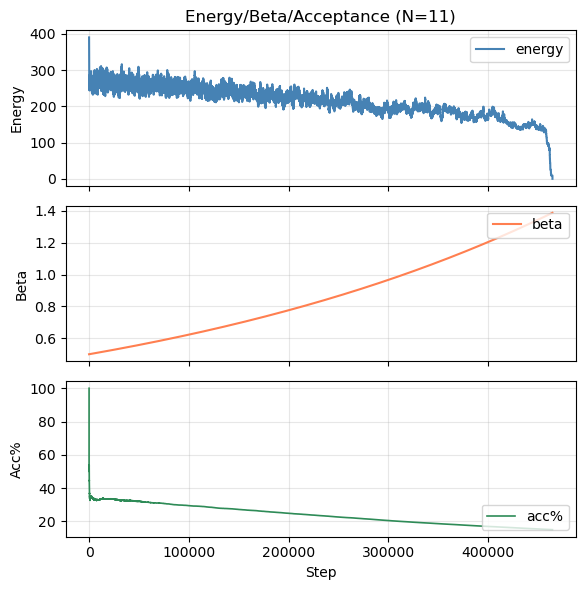

In [58]:
trace = run_mcmc(N=11, beta=0.5, beta_end=1.5, max_steps=500000, verbose=True, schedule="geometric", cooling_rate=1.001, seed=123)
plot_energy_curve(trace)

N=11, schedule=geometric:   0%|          | 0/8 [00:00<?, ?it/s]

N=11, num_zero_runs=8


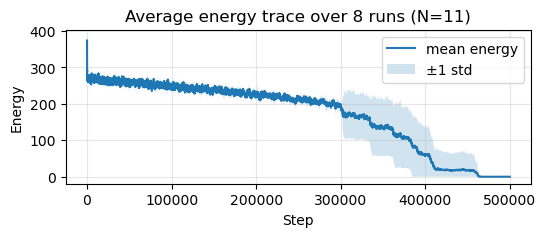

In [59]:
result = average_energy_over_runs(N=11, beta=0.5, beta_end=1.5, max_steps=500000, runs=8, base_seed=123, schedule="geometric", cooling_rate=1.001)
plot_energy_curve_average(*result)

step 2000: energy=638, beta=0.501, acc=36.0%
step 4000: energy=623, beta=0.502, acc=34.0%
step 6000: energy=638, beta=0.503, acc=32.9%
step 8000: energy=628, beta=0.504, acc=32.1%
step 10000: energy=648, beta=0.506, acc=31.7%
step 12000: energy=655, beta=0.507, acc=31.8%
step 14000: energy=659, beta=0.508, acc=31.6%
step 16000: energy=669, beta=0.509, acc=31.9%
step 18000: energy=631, beta=0.510, acc=31.9%
step 20000: energy=665, beta=0.511, acc=32.1%
step 22000: energy=666, beta=0.512, acc=32.1%
step 24000: energy=629, beta=0.513, acc=31.9%
step 26000: energy=655, beta=0.514, acc=31.8%
step 28000: energy=640, beta=0.516, acc=31.5%
step 30000: energy=654, beta=0.517, acc=31.6%
step 32000: energy=666, beta=0.518, acc=31.5%
step 34000: energy=636, beta=0.519, acc=31.5%
step 36000: energy=613, beta=0.520, acc=31.4%
step 38000: energy=640, beta=0.521, acc=31.4%
step 40000: energy=661, beta=0.522, acc=31.3%
step 42000: energy=641, beta=0.524, acc=31.4%
step 44000: energy=652, beta=0.525, ac

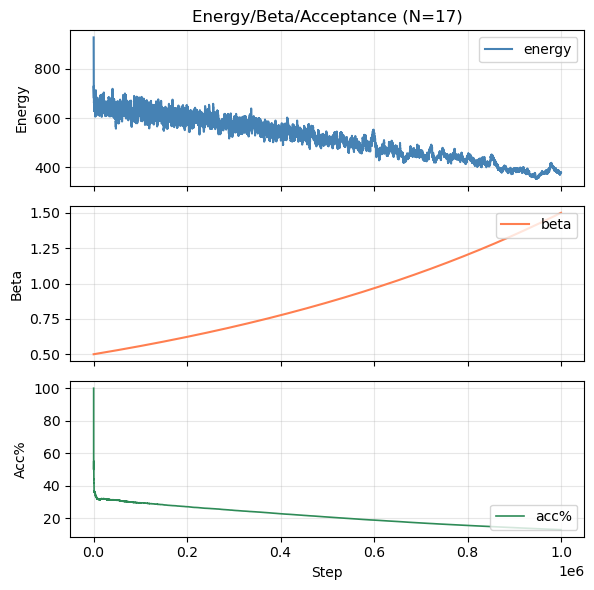

In [95]:
trace = run_mcmc(N=17, beta=0.5, beta_end=1.5, max_steps=1000000, verbose=True, schedule="geometric", cooling_rate=1.01, seed=123)
plot_energy_curve(trace)

## Comparing the effect of annealing

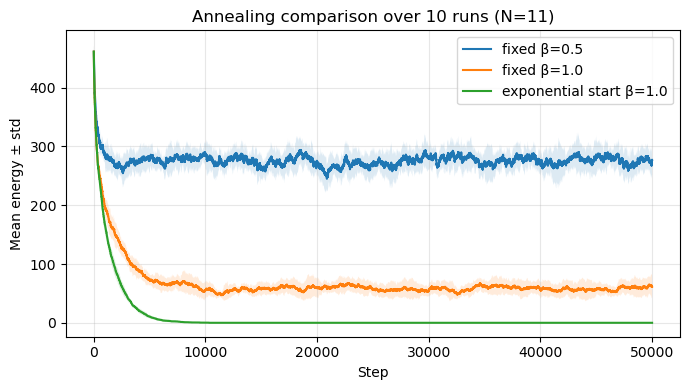

In [157]:
compare_annealing_effect(N=11, beta_fix1=0.5, beta_fix2=1.0, beta_exp=1.0, max_steps=50000, runs=10, base_seed=123, cooling_rate=1.001)

## Minimal energy vs. board size (annealing)

Use the simulated annealing routine for a sweep of N values and log the smallest energy observed. Larger N typically demand more annealing steps or repeated runs before the curve stabilizes.

In [158]:
def min_energy_vs_N(
    N_values,
    beta=1.0,
    max_steps=20000,
    runs=5,
    schedule="fixed",
    cooling_rate=1.001,
    target_energy=0,
    base_seed=None,
):
    """Run multiple MCMC chains per N and record the best energy found."""
    Ns = list(N_values)
    min_energies = []
    success_counts = []

    for idx, N in enumerate(Ns):
        best_energy = np.inf
        success = 0
        for run_idx in range(runs):
            seed = None if base_seed is None else base_seed + idx * runs + run_idx
            trace = run_mcmc(
                N=N,
                beta=beta,
                max_steps=max_steps,
                target_energy=target_energy,
                seed=seed,
                schedule=schedule,
                cooling_rate=cooling_rate,
                verbose=False,
            )
            best_energy = min(best_energy, trace.min_energy)
            if trace.min_energy <= target_energy:
                success += 1
        min_energies.append(best_energy)
        success_counts.append(success)

    return {
        "N_values": np.array(Ns),
        "min_energies": np.array(min_energies),
        "success_counts": np.array(success_counts),
        "runs": runs,
        "target_energy": target_energy,
        "schedule": schedule,
    }


def plot_min_energy_vs_N(result):
    Ns = result["N_values"]
    mins = result["min_energies"]
    success_rate = result["success_counts"] / result["runs"] * 100

    fig, ax1 = plt.subplots(figsize=(7, 4))
    ax1.plot(Ns, mins, marker="o", color="steelblue", label="min energy")
    ax1.set_xlabel("Board size N")
    ax1.set_ylabel("Best energy found")
    ax1.set_title("Best energy vs N")
    ax1.grid(True, alpha=0.3)
    if result["target_energy"] == 0:
        ax1.axhline(0, color="green", linestyle="--", linewidth=1)

    ax2 = ax1.twinx()
    ax2.plot(Ns, success_rate, marker="s", color="coral", label="success rate")
    ax2.set_ylabel("Success rate (%)")

    lines = ax1.get_lines() + ax2.get_lines()
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc="upper right")

    plt.tight_layout()
    plt.grid(True, alpha=0.3)
    plt.show()

Found energy 0 at step 68
Found energy 0 at step 231
Found energy 0 at step 482
Found energy 0 at step 127
Found energy 0 at step 304
Found energy 0 at step 561
Found energy 0 at step 163
Found energy 0 at step 881
Found energy 0 at step 284
Found energy 0 at step 489
Found energy 0 at step 744
Found energy 0 at step 993
Found energy 0 at step 726
Found energy 0 at step 1379
Found energy 0 at step 788
Found energy 0 at step 1451
Found energy 0 at step 1857
Found energy 0 at step 713
Found energy 0 at step 1618
Found energy 0 at step 2075
Found energy 0 at step 2405
Found energy 0 at step 953
Found energy 0 at step 3648
Found energy 0 at step 1484
Found energy 0 at step 2800
Found energy 0 at step 2666
Found energy 0 at step 4747
Found energy 0 at step 4714
Found energy 0 at step 2628
Found energy 0 at step 3023
Found energy 0 at step 3419
Found energy 0 at step 4271
Found energy 0 at step 6011
Found energy 0 at step 3682
Found energy 0 at step 4361
Found energy 0 at step 4086
Found ene

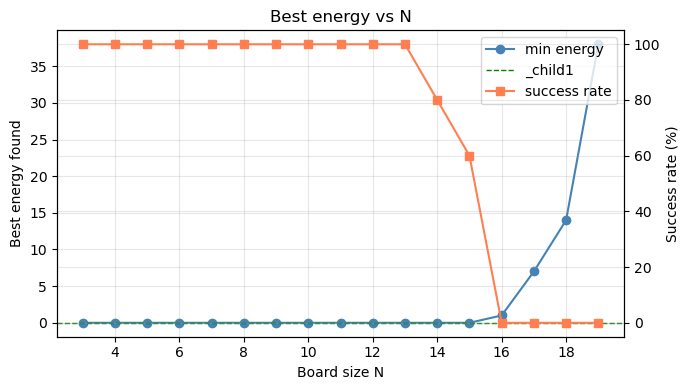

In [159]:
N_values = np.arange(3, 20)
result = min_energy_vs_N(N_values, beta=1.0, max_steps=20000, runs=5, schedule="exponential", cooling_rate=1.001, target_energy=0, base_seed=123)
plot_min_energy_vs_N(result)

## Optimal Solution illustration

In [9]:
def latin_queen_construction(N):
    a, b = 3, 5
    state = np.zeros((N, N), dtype=int)
    for i in range(N):
        for j in range(N):
            state[i, j] = (a * i + b * j) % N 
    return state

In [ ]:
N = 13
state = latin_queen_construction(N)
print(state)

print("energy of Latin-queen construction:", compute_energy(state))

[[ 0  5 10 15 20 25 30  4  9 14 19 24 29  3  8 13 18 23 28  2  7 12 17 22
  27  1  6 11 16 21 26]
 [ 3  8 13 18 23 28  2  7 12 17 22 27  1  6 11 16 21 26  0  5 10 15 20 25
  30  4  9 14 19 24 29]
 [ 6 11 16 21 26  0  5 10 15 20 25 30  4  9 14 19 24 29  3  8 13 18 23 28
   2  7 12 17 22 27  1]
 [ 9 14 19 24 29  3  8 13 18 23 28  2  7 12 17 22 27  1  6 11 16 21 26  0
   5 10 15 20 25 30  4]
 [12 17 22 27  1  6 11 16 21 26  0  5 10 15 20 25 30  4  9 14 19 24 29  3
   8 13 18 23 28  2  7]
 [15 20 25 30  4  9 14 19 24 29  3  8 13 18 23 28  2  7 12 17 22 27  1  6
  11 16 21 26  0  5 10]
 [18 23 28  2  7 12 17 22 27  1  6 11 16 21 26  0  5 10 15 20 25 30  4  9
  14 19 24 29  3  8 13]
 [21 26  0  5 10 15 20 25 30  4  9 14 19 24 29  3  8 13 18 23 28  2  7 12
  17 22 27  1  6 11 16]
 [24 29  3  8 13 18 23 28  2  7 12 17 22 27  1  6 11 16 21 26  0  5 10 15
  20 25 30  4  9 14 19]
 [27  1  6 11 16 21 26  0  5 10 15 20 25 30  4  9 14 19 24 29  3  8 13 18
  23 28  2  7 12 17 22]
 [30  4  9 14 19 24 

## MCMC driver


In [ ]:
# class MCMCTrace:
#     def __init__(self, energies, betas, accepted_moves, final_state, min_energy, iterations):
#         self.energies = energies
#         self.betas = betas
#         self.accepted_moves = accepted_moves
#         self.final_state = final_state
#         self.min_energy = min_energy
#         self.iterations = iterations


# def run_mcmc_chain(
#     N,
#     max_steps=20_000,
#     beta_0=0.1,
#     cooling_rate=1.001,
#     target_energy=0,
#     rng=None,
#     verbose=True,
# ):
#     if rng is None:
#         rng = np.random.default_rng()

#     state = random_state(N, rng)
#     energy = compute_energy(state)

#     energies = [energy]
#     betas = []
#     accepted = 0

#     for step in range(max_steps):
#         beta = exponential_beta(step, beta_0=beta_0, cooling_rate=cooling_rate)
#         betas.append(beta)

#         queen_idx = rng.integers(0, len(state))
#         new_pos = tuple(rng.integers(1, N + 1, size=3))
#         delta = compute_delta_energy(state, queen_idx, new_pos)

#         if metropolis_accept(delta, beta, rng):
#             state[queen_idx] = new_pos
#             energy += delta
#             accepted += 1

#         energies.append(energy)

#         if verbose and (step + 1) % 2000 == 0:
#             acc_rate = 100 * accepted / (step + 1)
#             print(f"step {step+1}: energy={energy}, β={beta:.3f}, acc={acc_rate:.1f}%")

#         if energy <= target_energy:
#             if verbose:
#                 print(f"✓ found energy {energy} at step {step}")
#             break

#     return MCMCTrace(
#         energies=np.array(energies),
#         betas=np.array(betas),
#         accepted_moves=accepted,
#         final_state=state,
#         min_energy=int(np.min(energies)),
#         iterations=len(betas),
#     )


## Visualization helpers


In [43]:
def plot_trace(trace):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    ax = axes[0]
    ax.plot(trace.energies, color='steelblue', linewidth=1.5)
    ax.axhline(0, color='green', linestyle='--', linewidth=1)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Energy (attacking pairs)')
    ax.set_title('Energy trajectory')

    ax = axes[1]
    ax.semilogy(trace.betas, color='coral', linewidth=1.5)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('β (inverse temperature)')
    ax.set_title('Exponential cooling schedule')

    plt.tight_layout()
    plt.show()

    print(
        f"min energy={trace.min_energy}, iterations={trace.iterations}, "
        f"accepted moves={trace.accepted_moves}"
    )


## Example run


step 2000: energy=196, β=2.714, acc=55.3%
step 4000: energy=44, β=147.567, acc=31.1%
step 6000: energy=16, β=8024.749, acc=22.1%
step 8000: energy=2, β=436389.741, acc=17.9%
✓ found energy 0 at step 9875


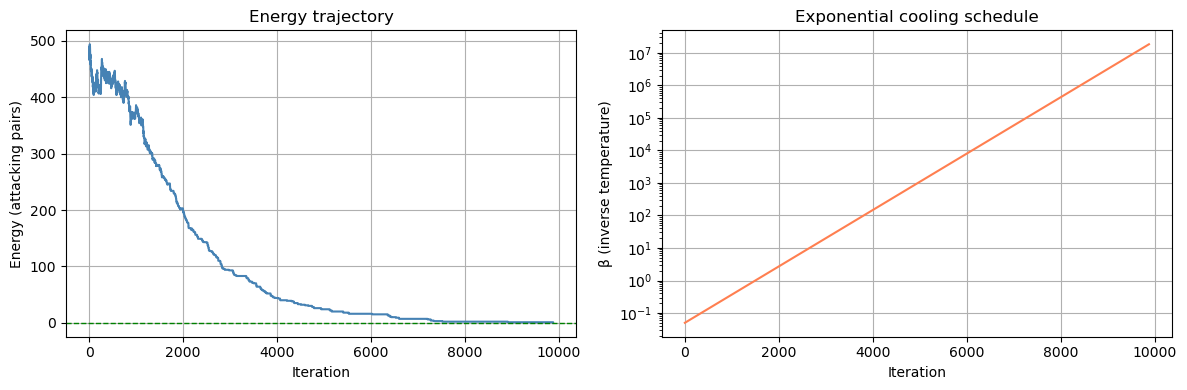

min energy=0, iterations=9876, accepted moves=1527


In [44]:
N = 11
max_steps = 25_000
beta_0 = 0.05
cooling = 1.002
rng = np.random.default_rng(42)

trace = run_mcmc_chain(
    N=N,
    max_steps=max_steps,
    beta_0=beta_0,
    cooling_rate=cooling,
    target_energy=0,
    rng=rng,
)
plot_trace(trace)
